# Weather Image Classify MONAI Pytorch


## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

In [3]:
data_dir = '../input/weather-dataset/dataset' 
class_names = os.listdir(data_dir)
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

In [4]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [5]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 6862
Image dimensions: 785 x 797
Label names: ['hail', 'rainbow', 'frost', 'rime', 'fogsmog', 'snow', 'rain', 'glaze', 'lightning', 'sandstorm', 'dew']
Label counts: [591, 232, 475, 1160, 851, 621, 526, 639, 377, 692, 698]


## Visualise some examples

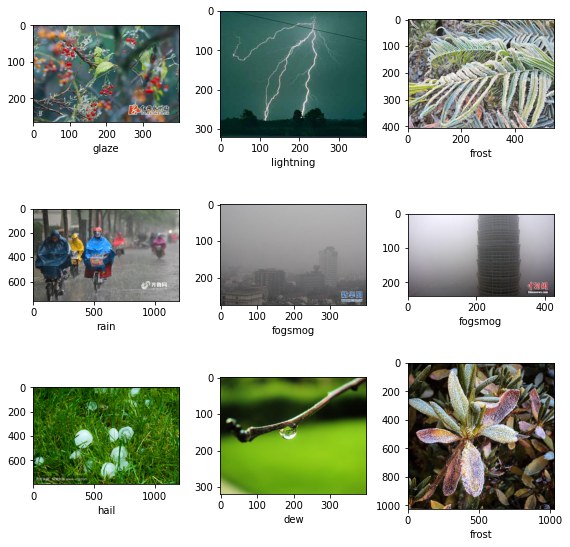

In [6]:
plt.subplots(3,3, figsize=(8,8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

In [7]:
valid_frac, test_frac = 0.1, 0.1
trainX,trainY = [],[]
valX,valY = [],[]
testX,testY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX),len(testX))

5486 674 702


In [8]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(testX)
testY=np.array(testY)

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [10]:
class MyResize(Transform):
    def __init__(self, size=(100,100)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [11]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


In [12]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [13]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

In [14]:
device = torch.device("cuda:0")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 30
val_interval = 1

In [15]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### .float()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/30
1/85, train_loss: 2.4742
2/85, train_loss: 2.4504
3/85, train_loss: 2.4094
4/85, train_loss: 2.4265
5/85, train_loss: 2.3958
6/85, train_loss: 2.4180
7/85, train_loss: 2.4044
8/85, train_loss: 2.3843
9/85, train_loss: 2.3625
10/85, train_loss: 2.3585
11/85, train_loss: 2.3575
12/85, train_loss: 2.3499
13/85, train_loss: 2.3794
14/85, train_loss: 2.2999
15/85, train_loss: 2.2803
16/85, train_loss: 2.3202
17/85, train_loss: 2.2923
18/85, train_loss: 2.3383
19/85, train_loss: 2.3172
20/85, train_loss: 2.2216
21/85, train_loss: 2.3369
22/85, train_loss: 2.3353
23/85, train_loss: 2.3061
24/85, train_loss: 2.2849
25/85, train_loss: 2.3010
26/85, train_loss: 2.2018
27/85, train_loss: 2.3178
28/85, train_loss: 2.2152
29/85, train_loss: 2.1880
30/85, train_loss: 2.3266
31/85, train_loss: 2.2135
32/85, train_loss: 2.1640
33/85, train_loss: 2.2085
34/85, train_loss: 2.1822
35/85, train_loss: 2.1630
36/85, train_loss: 2.2540
37/85, train_loss: 2.1988
38/85, train_loss: 2.1865

## Plot the loss and metric

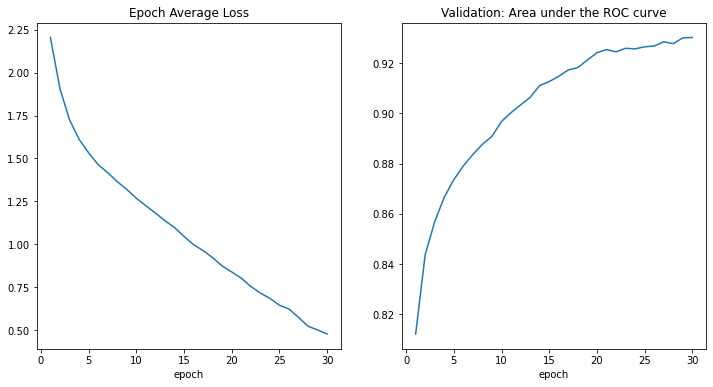

In [16]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [17]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [18]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        hail     0.6491    0.5781    0.6116        64
     rainbow     0.4091    0.6000    0.4865        15
       frost     0.5965    0.6538    0.6239        52
        rime     0.7653    0.6696    0.7143       112
     fogsmog     0.7590    0.7079    0.7326        89
        snow     0.4831    0.6232    0.5443        69
        rain     0.5370    0.5577    0.5472        52
       glaze     0.6071    0.5152    0.5574        66
   lightning     0.8857    0.7949    0.8378        39
   sandstorm     0.6250    0.5634    0.5926        71
         dew     0.6322    0.7534    0.6875        73

    accuracy                         0.6410       702
   macro avg     0.6318    0.6379    0.6305       702
weighted avg     0.6529    0.6410    0.6436       702

